In [131]:

from numpy.random import seed
seed(123)

from tensorflow.python.framework.random_seed import set_random_seed
set_random_seed(123)


import numpy as np
import pandas as pd

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

import os
print(os.listdir("/Users/nouf/Desktop/archive"))
from sklearn.model_selection import train_test_split



['.DS_Store', 'dataA', 'dataB', 'dataE', 'dataD', 'dataC']


In [181]:
image_path = ["/Users/nouf/Desktop/archive/"+"data"+i+"/"+"data"+i+"/CameraRGB/" for i in ['A', 'B', 'C', 'D', 'E']]
mask_path = ["/Users/nouf/Desktop/archive/"+"data"+i+"/"+"data"+i+"/CameraSeg/" for i in ['A', 'B', 'C', 'D', 'E']]

In [182]:
def list_image_paths(directory_paths):
    image_paths = []
    for directory in range(len(directory_paths)):
        image_filenames = os.listdir(directory_paths[directory])
        for image_filename in image_filenames:
            image_paths.append(directory_paths[directory] + image_filename)
    return image_paths

In [183]:
image_paths = list_image_paths(image_path) 
mask_paths = list_image_paths(mask_path)
number_of_images, number_of_masks = len(image_paths), len(mask_paths)
print(f"1. There are {number_of_images} images and {number_of_masks} masks in our dataset")
print(f"2. An example of an image path is: \n {image_paths[0]}")
print(f"3. An example of a mask path is: \n {mask_paths[0]}")

1. There are 5000 images and 5000 masks in our dataset
2. An example of an image path is: 
 /Users/nouf/Desktop/archive/dataA/dataA/CameraRGB/F7-31.png
3. An example of a mask path is: 
 /Users/nouf/Desktop/archive/dataA/dataA/CameraSeg/F7-31.png


In [132]:
# image_path = '/Users/nouf/Desktop/archive/dataA/dataA/CameraRGB/'
# mask_path = '/Users/nouf/Desktop/archive/dataA/dataA/CameraSeg/'
# image_list = os.listdir(image_path)
# mask_list = os.listdir(mask_path)
# image_list = [image_path+i for i in image_list]
# mask_list = [mask_path+i for i in mask_list]

In [186]:
X = image_paths
Y = mask_paths

In [187]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size = 0.2)

In [193]:
def read_imageMask(image_path, mask_path):
    
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (128, 128), method='nearest')
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    mask = tf.image.resize(mask, (128, 128), method='nearest')
    
    return img, mask

In [194]:
def data_generator(image_paths, mask_paths, batch_size):
    images = tf.constant(image_paths)
    masks = tf.constant(mask_paths)
    dataset = tf.data.Dataset.from_tensor_slices((images, masks))
    dataset = dataset.map(read_imageMask, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache().shuffle(500).batch(batch_size)
    
    return dataset

In [195]:
train_generator = data_generator(X_train, Y_train, 32)
val_generator = data_generator(X_val, Y_val, 32)
test_generator = data_generator(X_test, Y_test, 32)

In [197]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [198]:
from tensorflow_examples.models.pix2pix import pix2pix

In [199]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [200]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [201]:
import tensorflow as tf

In [202]:
OUTPUT_CLASSES = 13

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [203]:
from tensorflow.keras.callbacks import EarlyStopping

In [204]:
earlystopping = EarlyStopping(monitor='val_loss', patience= 5)

In [205]:
history = model.fit(train_generator, validation_data=val_generator,epochs=50,
                    verbose = 1, batch_size=16,
                    callbacks=[earlystopping])

Epoch 1/50
125/125 [==============================] - 186s 1s/step - loss: 0.6720 - accuracy: 0.8203 - val_loss: 0.3712 - val_accuracy: 0.9065
Epoch 2/50
125/125 [==============================] - 160s 1s/step - loss: 0.2299 - accuracy: 0.9324 - val_loss: 0.2385 - val_accuracy: 0.9321
Epoch 3/50
125/125 [==============================] - 145s 1s/step - loss: 0.1732 - accuracy: 0.9454 - val_loss: 0.1747 - val_accuracy: 0.9444
Epoch 4/50
125/125 [==============================] - 145s 1s/step - loss: 0.1475 - accuracy: 0.9518 - val_loss: 0.1510 - val_accuracy: 0.9508
Epoch 5/50
125/125 [==============================] - 156s 1s/step - loss: 0.1328 - accuracy: 0.9557 - val_loss: 0.1371 - val_accuracy: 0.9542
Epoch 6/50
125/125 [==============================] - 142s 1s/step - loss: 0.1220 - accuracy: 0.9587 - val_loss: 0.1272 - val_accuracy: 0.9566
Epoch 7/50
125/125 [==============================] - 164s 1s/step - loss: 0.1141 - accuracy: 0.9609 - val_loss: 0.1217 - val_accuracy: 0.9581

In [206]:
train_loss, train_accuracy = model.evaluate(train_generator, batch_size = 32)
validation_loss, validation_accuracy = model.evaluate(val_generator, batch_size = 32)
test_loss, test_accuracy = model.evaluate(test_generator, batch_size = 32)

7/7 [==============================] - 4s 441ms/step - loss: 0.0987 - accuracy: 0.9675


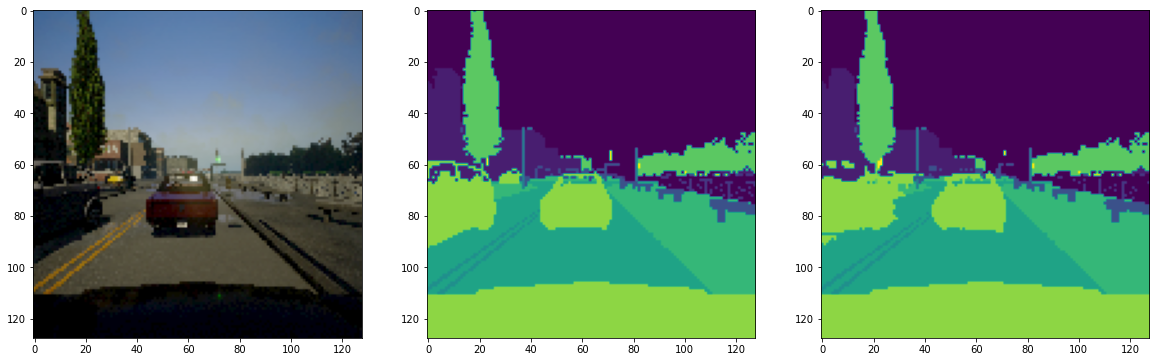

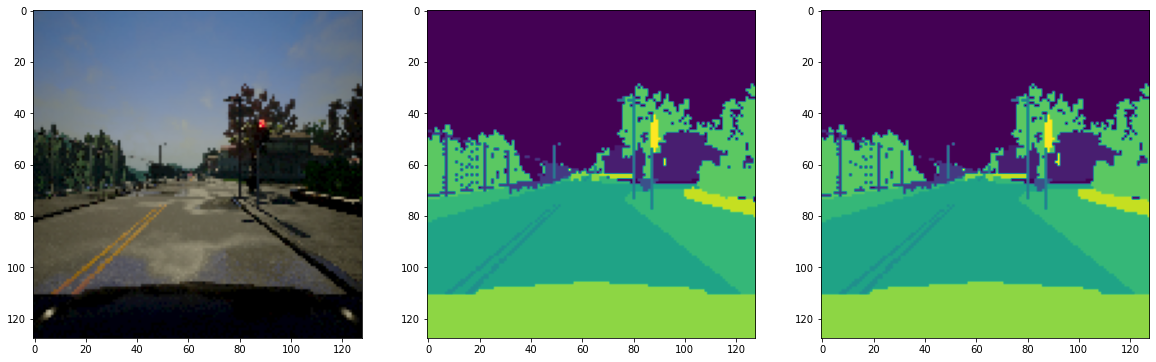

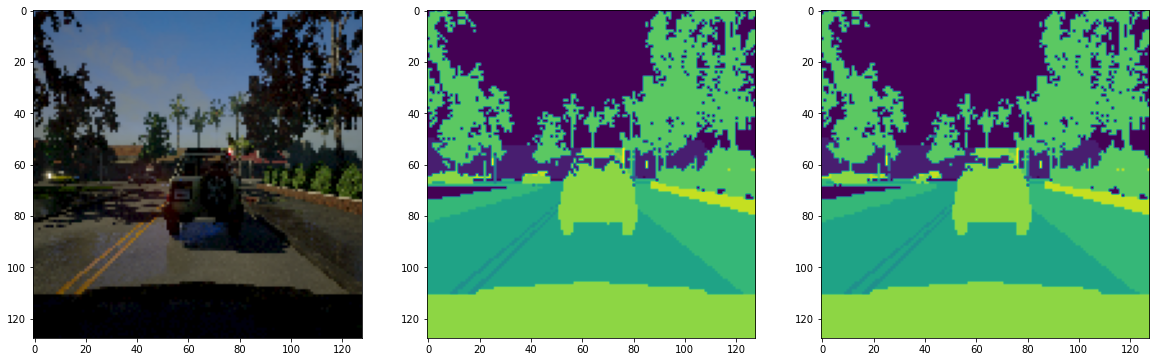

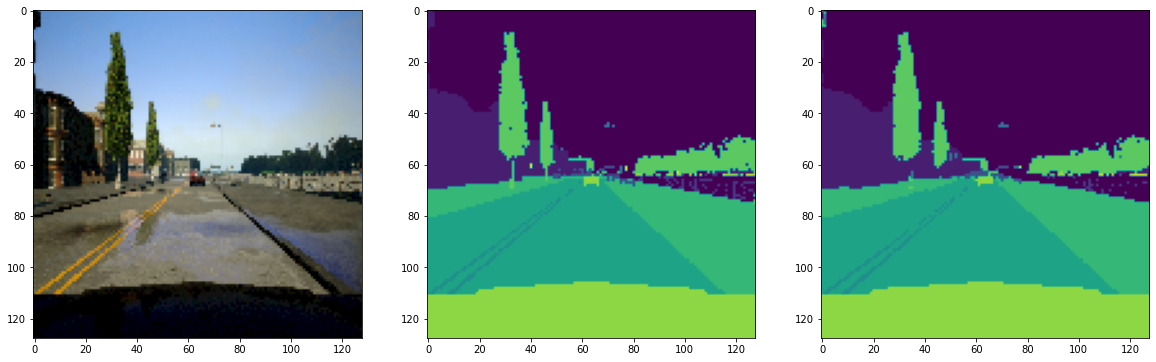

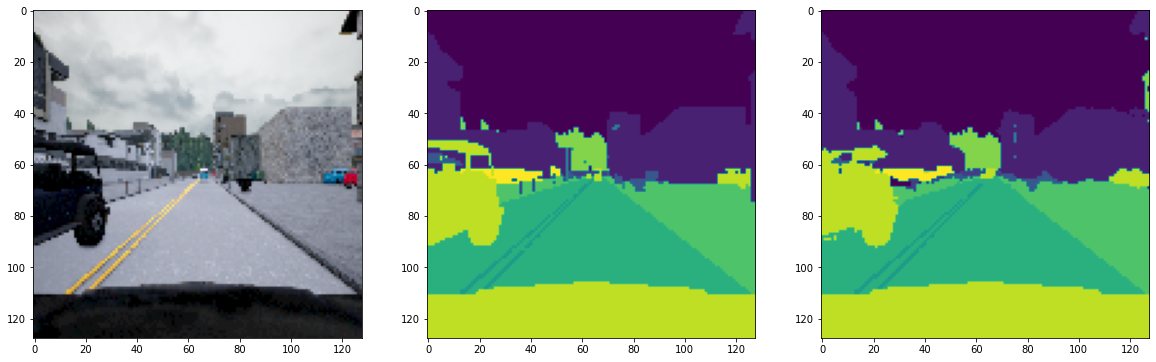

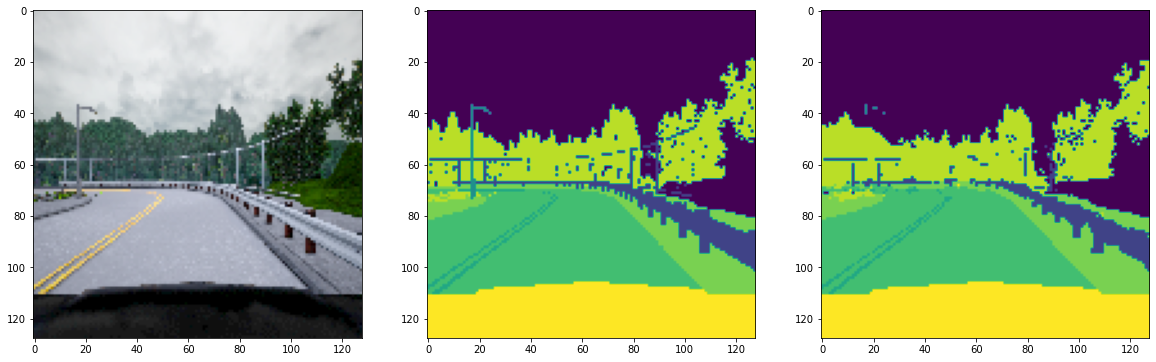

In [207]:
for image, mask in test_generator.take(6):
    pred_mask = model.predict(image)
    
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(image[0]))
    plt.subplot(1, 3, 2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[0]))
    plt.subplot(1, 3, 3)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(tf.expand_dims(tf.argmax(pred_mask[0], axis = -1), axis = -1)))

In [208]:
def create_mask(dataset, model):
    true_masks, predicted_masks = [], []
    for images, masks in dataset:
        pred_masks = model.predict(images)
        pred_masks = tf.expand_dims(tf.argmax(pred_masks, axis=-1), axis=-1)
        true_masks.extend(masks)
        predicted_masks.extend(pred_masks)
        
    true_masks = np.array(true_masks)
    predicted_masks = np.array(predicted_masks)
        
    return true_masks, predicted_masks    

In [209]:
true_train_masks, predicted_train_masks = create_mask(train_generator, model)
true_validation_masks, predicted_validation_masks = create_mask(val_generator, model)
true_test_masks, predicted_test_masks = create_mask(test_generator, model)

In [210]:
def evaluate_model(true_masks, predicted_masks, n_classes, smooth = 1e-6):
    
    """
    Evaluates semantic segmentation model
    
    Argument:
        true_masks: ground truth segmentations
        predicted_masks: predicted segmentations
        n_classes: number of segmentation classes
        smooth: a minute float digit added to denominators to avoid error from a zero division
    
    Returns:
        class_wise_evaluations: a dictionary containing evaluation metric 
                                outputs the for each segmentation class 
        overall_evaluations: a dictionary containing evaluation metric 
                             outputs the for all segmentation classes
        """
    # Create empty lists to store evaluation metric outputs
    class_wise_true_positives, class_wise_true_negatives = [],[]
    class_wise_false_positives, class_wise_false_negatives = [],[]
    class_wise_precisions, class_wise_recalls = [],[] 
    class_wise_specificities, class_wise_ious = [],[] 
    class_wise_tdrs, class_wise_f1_scores = [],[]
    classes = []
            
    for clas in range(n_classes):
        true_positives, true_negatives, false_positives, false_negatives = 0,0,0,0
        precisions, recalls, specificities, ious, f1_scores, tdrs = 0,0,0,0,0,0        
        
        number_of_masks = true_masks.shape[0]
        
        for mask_id in range(number_of_masks):
            true_positive = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]==clas))
            true_negative = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]!=clas))
            false_positive = np.sum(np.logical_and(true_masks[mask_id]!=clas, predicted_masks[mask_id]==clas))
            false_negative = np.sum(np.logical_and(true_masks[mask_id]==clas, predicted_masks[mask_id]!=clas))
            
            true_positives += true_positive
            true_negatives += true_negative
            false_positives += false_positive
            false_negatives += false_negative

        recall = round(true_positives/(true_positives + false_negatives + smooth), 2)
        precision = round(true_positives/(true_positives + false_positives + smooth), 2)
        specificity = round(true_negatives/(true_negatives + false_positives + smooth), 2)
        tdr = round((1 - (false_negatives/(true_positives + false_negatives + smooth))), 2)
        iou = round(true_positives/(true_positives + false_negatives + false_positives + smooth), 2)
        f1_score = round((2 * precision * recall)/(precision + recall + smooth), 2)
        
        class_wise_true_positives.append(true_positives)
        class_wise_true_negatives.append(true_negatives)
        class_wise_false_positives.append(false_positives)
        class_wise_false_negatives.append(false_negatives)
        class_wise_recalls.append(recall)
        class_wise_precisions.append(precision)
        class_wise_specificities.append(specificity)
        class_wise_ious.append(iou)
        class_wise_tdrs.append(tdr)
        class_wise_f1_scores.append(f1_score)
        classes.append("Class " + str(clas+1))
        # class_wise_pixel_accuracies.append(pixel_accuracy)
        
    total_true_positives = np.sum(class_wise_true_positives)
    total_true_negatives = np.sum(class_wise_true_negatives)
    total_false_positives = np.sum(class_wise_false_positives)
    total_false_negatives = np.sum(class_wise_false_negatives)
    mean_recall = round(np.average(np.array(class_wise_recalls)), 2)
    mean_precision = round(np.average(np.array(class_wise_precisions)), 2)
    mean_specificity = round(np.average(np.array(class_wise_specificities)), 2)
    mean_iou = round(np.average(np.array(class_wise_ious)), 2)
    mean_tdr = round(np.average(np.array(class_wise_tdrs)), 2)
    mean_f1_score = round(np.average(np.array(class_wise_f1_scores)), 2)    
         
    class_wise_evaluations = {"Class": classes,
                              "True Positive Pixels": class_wise_true_positives,
                              "True Negative Pixels": class_wise_true_negatives,
                              "False Positive Pixels": class_wise_false_positives,
                              "False Negative Pixels": class_wise_false_negatives,
                              "Recall": class_wise_recalls,
                              "Precision": class_wise_precisions,
                              "Specificity": class_wise_specificities,
                              "IoU": class_wise_ious,
                              "TDR": class_wise_tdrs,
                              "F1-Score": class_wise_f1_scores}

    overall_evaluations = {"Class": "All Classes",
                        "True Positive Pixels": total_true_positives,
                        "True Negative Pixels": total_true_negatives,
                        "False Positive Pixels": total_false_positives,
                        "False Negative Pixels": total_false_negatives,
                        "Recall": mean_recall,
                        "Precision": mean_precision,
                        "Specificity": mean_specificity,
                        "IoU": mean_iou,
                        "TDR": mean_tdr,
                        "F1-Score": mean_f1_score}
    
    evaluations = {"Overall Evaluations": overall_evaluations, 
                   "Class-wise Evaluations": class_wise_evaluations}
    
    return evaluations

In [211]:
def show_evaluations(evaluations, 
                     metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1 Score"], 
                     class_list=None,
                     display_evaluations="All"):
    """
    Returns a pandas dataframe containing specified metrics
        
        Arguments:
            evaluations: evaluation output from the evaluate_model function
            metrics: a list containing one or more of the following metrics:
                     'True Positive', 'True Negative', 'False Positive', 'False Negative',
                     'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'
            display_evaluations: one of 'All' to display both overall and class-wise evaluations,
                                 'Overall' to display only the overall evaluations,
                                 'Class-wise' to display only the classwise evaluations.
            class_list: list or tuple containing names of segmentation class.
    """
    
    # Split evaluations into overall and class-wise evaluations
    overall_evaluations = evaluations["Overall Evaluations"]
    class_wise_evaluations = evaluations["Class-wise Evaluations"]
    
    # Validate list of metrics 
    for metric_id in range(len(metrics)):
        metric = metrics[metric_id]
        if metric not in overall_evaluations:
            raise ValueError("'metrics argument' not properly defined. "
                            "Kindly create a list containing one or more of the following metrics: "
                             "'True Positive', 'True Negative', 'False Positive', 'False Negative', "
                             "'Recall', 'Precision', 'Specificity', 'F1 Score', 'IoU', 'TDR'") 
    
    # Check if class_list is none
    if class_list != None and all(isinstance(class_, str) for class_ in class_list):
        if len(class_list) == len(class_wise_evaluations["Class"]):
            class_list = [class_list]
        else:
            raise ValueError("class_list argument' not properly defined. " 
                             "List is either shorter or longer than segmentation classes") 
    else:
        class_list = [class_wise_evaluations["Class"]]                             
    
    # Extract data from the evaluations
    overall_data = [overall_evaluations["Class"]] + [overall_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    classwise_data = class_list + [class_wise_evaluations[metrics[metric_id]] for metric_id in range(len(metrics))]
    overall_data = np.array(overall_data).reshape(1,-1)
    classwise_data = np.array(classwise_data).transpose()
    
    # Determine the type of evaluation report to display
    if display_evaluations.lower() == "all":
        data = np.concatenate((overall_data, classwise_data), axis=0)
    elif display_evaluations.lower() == "overall":
        data = overall_data
    elif display_evaluations.lower() == "class-wise" or "classwise":
        data = classwise_data
    else:
        raise ValueError("Display argument are not properly defined."
                        "Kindly use 'All' to display both overall and class-wise evaluations."
                        "Use 'Overall' to display only the overall evaluations."
                        "Or use 'Class-wise' to display only the class-wise evaluations")

    
    # Create evaluation report as a pandas dataframe
    dataframe = pd.DataFrame(data)
    dataframe_titles = ["Class"] + metrics
    dataframe.columns = dataframe_titles
    # dataframe = dataframe.set_index(dataframe_titles[0], col_level=1)
    
    return dataframe

In [212]:
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=13)

show_evaluations(model_evaluation_on_train_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.87,0.92,1.0,0.82,0.87,0.89
1,Class 1,0.99,0.98,0.99,0.97,0.99,0.98
2,Class 2,0.98,0.97,1.0,0.95,0.98,0.97
3,Class 3,0.65,0.86,1.0,0.59,0.65,0.74
4,Class 4,0.85,0.86,1.0,0.75,0.85,0.85
5,Class 5,0.54,0.84,1.0,0.49,0.54,0.66
6,Class 6,0.76,0.88,1.0,0.69,0.76,0.82
7,Class 7,0.91,0.93,1.0,0.86,0.91,0.92
8,Class 8,0.99,0.99,1.0,0.99,0.99,0.99
9,Class 9,0.97,0.97,1.0,0.95,0.97,0.97


In [223]:
y_true = true_train_masks
y_pred = predicted_train_masks

In [224]:
# one hot encoding of predictions
num_classes = y_pred.shape[-1]
y_pred = np.array([ np.argmax(y_pred, axis=-1)==i for i in range(num_classes) ]).transpose(1,2,3,0)

axes = (1,2) # W,H axes of each image
intersection = np.sum(np.logical_and(y_pred, y_true), axis=axes)
# intersection = np.sum(np.abs(y_pred * y_true), axis=axes)
union = np.sum(np.logical_or(y_pred, y_true), axis=axes)
mask_sum = np.sum(np.abs(y_true), axis=axes) + np.sum(np.abs(y_pred), axis=axes)
# union = mask_sum  - intersection

smooth = .001
iou = (intersection + smooth) / (union + smooth)
dice = 2 * (intersection + smooth)/(mask_sum + smooth)

iou = np.mean(iou)
dice = np.mean(dice)

In [225]:
iou

0.6900816839549753

In [226]:
model_evaluation_on_train_dataset = evaluate_model(true_train_masks, predicted_train_masks, n_classes=13)

show_evaluations(model_evaluation_on_train_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.87,0.92,1.0,0.82,0.87,0.89
1,Class 1,0.99,0.98,0.99,0.97,0.99,0.98
2,Class 2,0.98,0.97,1.0,0.95,0.98,0.97
3,Class 3,0.65,0.86,1.0,0.59,0.65,0.74
4,Class 4,0.85,0.86,1.0,0.75,0.85,0.85
5,Class 5,0.54,0.84,1.0,0.49,0.54,0.66
6,Class 6,0.76,0.88,1.0,0.69,0.76,0.82
7,Class 7,0.91,0.93,1.0,0.86,0.91,0.92
8,Class 8,0.99,0.99,1.0,0.99,0.99,0.99
9,Class 9,0.97,0.97,1.0,0.95,0.97,0.97


In [227]:
model_evaluation_on_train_dataset = evaluate_model(true_validation_masks, predicted_validation_masks, n_classes=13)

show_evaluations(model_evaluation_on_train_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.79,0.87,1.0,0.73,0.79,0.81
1,Class 1,0.99,0.98,0.99,0.97,0.99,0.98
2,Class 2,0.96,0.94,0.99,0.91,0.96,0.95
3,Class 3,0.59,0.8,1.0,0.51,0.59,0.68
4,Class 4,0.73,0.78,1.0,0.6,0.73,0.75
5,Class 5,0.18,0.71,1.0,0.17,0.18,0.29
6,Class 6,0.49,0.72,1.0,0.41,0.49,0.58
7,Class 7,0.89,0.91,1.0,0.82,0.89,0.9
8,Class 8,0.99,0.99,1.0,0.98,0.99,0.99
9,Class 9,0.96,0.95,1.0,0.91,0.96,0.95


In [228]:
model_evaluation_on_train_dataset = evaluate_model(true_test_masks, predicted_test_masks, n_classes=13)

show_evaluations(model_evaluation_on_train_dataset, 
                 metrics=["Recall", "Precision", "Specificity", "IoU", "TDR", "F1-Score"], 
                 class_list=None, 
                 display_evaluations="All")

,Class,Recall,Precision,Specificity,IoU,TDR,F1-Score
0,All Classes,0.81,0.87,1.0,0.74,0.81,0.83
1,Class 1,0.99,0.98,0.99,0.97,0.99,0.98
2,Class 2,0.96,0.94,0.99,0.9,0.96,0.95
3,Class 3,0.64,0.82,1.0,0.56,0.64,0.72
4,Class 4,0.74,0.79,1.0,0.62,0.74,0.76
5,Class 5,0.23,0.64,1.0,0.2,0.23,0.34
6,Class 6,0.55,0.77,1.0,0.47,0.55,0.64
7,Class 7,0.89,0.92,1.0,0.83,0.89,0.9
8,Class 8,0.99,0.99,1.0,0.98,0.99,0.99
9,Class 9,0.96,0.95,1.0,0.91,0.96,0.95
